In [65]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Estimates from Factor Model
We assume a factor model where there are k assets and T time periods (months in our case), m is the common factors (topic weights in our case). $r_{it}$ is the return for asset $i$ at time $t$.

$$
\begin{align}
r_{it}
= &\alpha_i + \sum_{j=1}^{m} \beta_{ij} f_jt + \epsilon_{it}, t = 1, \dots, T, i = 1, \dots, k\\ \\
R_{k \times T} = & B_{k \times m} \cdot coef_{m \times T} + \epsilon_{k \times T}
\end{align}
$$

In our analysis, $R_{k \times T}$ is the returns matrix imported, $B_{k \times m}$ is the topic modeling matrix, and $coef_{m \times T}$ is the coefficient matrix computed after the linear regression on returns matrix and topic modeling matrix. $\epsilon_{k \times T}$ is the residual matrix.

In our factor model, $\text{Cov}(r) = \beta \Sigma_{coef} \beta^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k)$

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [67]:
r_selected = pd.read_csv("data/filtered_r.csv")
# get the mean of all 
r_selected.set_index("name", inplace = True)
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

In [68]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK', 'coDescription',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

### Sent-LDA
We ran the coherence score benchmarking over a range of 3 to 40 topics, incrementing by 3. 

First, we fit the LDA model to all business description using the number of topics selected from coherence score benchmarking. 

Then, we assume each sentence only represents one topic; get the frequency of the topics revealed in the whole document (business description for one company) and calculate the probability of each topics in the whole document. 

#### Coherence Score Plot

<div>
<img src="images/Factor_Model_Coherence_Score.png" width="500"/>
</div>

In [ ]:
Based on the above Coherence Score, we choose up to 12 topics since it gives the highest score up to here.

In [5]:
data = df.loc[:,"coDescription_stopwords"].to_list()

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=600)
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=12, random_state=0).fit(tf)

We show the top 10 words by weights in the 12 topics LDA model generates in the below table.

In [7]:
std_func.get_topics(lda, tf_vectorizer, 12)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,could,loan,share,product,investment,gas,hotel,patient,bank,customer,million,cell
1,gas,mortgage,stock,drug,income,oil,facility,treatment,capital,service,tax,cancer
2,regulation,real,note,fda,asset,natural,tenant,trial,institution,data,asset,tumor
3,oil,estate,issued,clinical,reit,production,lease,study,federal,product,net,product
4,future,commercial,preferred,patent,real,reserve,operating,phase,act,solution,income,therapy
5,natural,bank,date,approval,tax,proved,estate,clinical,banking,software,cash,therapeutic
6,price,interest,amount,trial,share,drilling,million,disease,holding,platform,expense,clinical
7,affect,rate,september,application,interest,regulation,real,drug,regulation,technology,value,technology
8,ability,million,per,regulatory,distribution,net,center,therapy,deposit,application,note,research
9,adversely,security,director,candidate,estate,water,portfolio,data,asset,sale,statement,license


#### Frequency of the Topics in Each Sentence

In [8]:
n_components = 12
prob = pd.DataFrame(0, index = df.name, columns = range(n_components))

In [9]:
for j in range(len(df)):
    LIST_sent = pd.Series(df.coDescription[j].split('.')).apply(std_func.lemmatize_sentence).apply(std_func.remove_nums).apply(std_func.remove_stopwords)
    
    X = tf_vectorizer.transform(LIST_sent.tolist())
    sent = lda.transform(X)
    sent_df = pd.DataFrame(sent)
    # drop the values that are smaller than 1/12
    # if the maximum value is 1/12, the probability of each topic in that sentence is the same
    # we cannot determine which topic to choose
    sent_df = sent_df[sent_df.max(axis = 1) > 1/12].reset_index(drop = True)

    for i in range(n_components):
        prob.iloc[j][i] = list(sent_df.idxmax(axis = 1)).count(i)
    
    # calculate the probability
    prob = prob.div(prob.sum(axis=1), axis=0)

In [69]:
prob

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
"MONGODB, INC.",0.014652,0.007326,0.021978,0.036630,0.018315,0.010989,0.040293,0.021978,0.014652,0.739927,0.047619,0.025641
SALESFORCE COM INC,0.010811,0.010811,0.005405,0.016216,0.000000,0.021622,0.037838,0.005405,0.005405,0.821622,0.054054,0.010811
SPLUNK INC,0.010274,0.003425,0.013699,0.020548,0.013699,0.003425,0.023973,0.000000,0.003425,0.839041,0.058219,0.010274
"OKTA, INC.",0.020305,0.000000,0.015228,0.050761,0.015228,0.005076,0.040609,0.000000,0.015228,0.786802,0.030457,0.020305
VEEVA SYSTEMS INC,0.093245,0.012845,0.094196,0.028544,0.035205,0.008563,0.019981,0.010466,0.017602,0.315414,0.352046,0.011893
...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",0.075472,0.084906,0.122642,0.009434,0.471698,0.009434,0.075472,0.000000,0.000000,0.066038,0.084906,0.000000
"CYCLACEL PHARMACEUTICALS, INC.",0.027460,0.000000,0.029748,0.272311,0.011442,0.009153,0.018307,0.308924,0.000000,0.029748,0.013730,0.279176
ZOETIS INC.,0.036519,0.018868,0.074254,0.033475,0.034084,0.013999,0.035301,0.018868,0.020694,0.053561,0.644553,0.015825


#### Demonstration in Pharmaceutical Preparations Industry

In [190]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [191]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

In [192]:
B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

In [193]:
B_matrix

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
"PACIRA PHARMACEUTICALS, INC.",0.000000,0.000000,0.080000,0.240000,0.040000,0.040000,0.160000,0.120000,0.080000,0.160000,0.040000,0.040000
"ZYNERBA PHARMACEUTICALS, INC.",0.057471,0.000000,0.011494,0.091954,0.000000,0.000000,0.000000,0.678161,0.000000,0.034483,0.011494,0.114943
ACHILLION PHARMACEUTICALS INC,0.034200,0.006840,0.073871,0.538988,0.020520,0.004104,0.013680,0.166895,0.019152,0.050616,0.016416,0.054720
PFIZER INC,0.000000,0.000000,0.046512,0.255814,0.046512,0.000000,0.139535,0.116279,0.046512,0.116279,0.186047,0.046512
SYNDAX PHARMACEUTICALS INC,0.027174,0.005435,0.052536,0.322464,0.018116,0.007246,0.021739,0.271739,0.010870,0.036232,0.030797,0.195652
...,...,...,...,...,...,...,...,...,...,...,...,...
BIOMARIN PHARMACEUTICAL INC,0.045455,0.000000,0.000000,0.386364,0.022727,0.000000,0.000000,0.431818,0.000000,0.000000,0.022727,0.090909
RIGEL PHARMACEUTICALS INC,0.018832,0.016949,0.047081,0.290019,0.011299,0.013183,0.007533,0.242938,0.013183,0.069680,0.071563,0.197740
EVOKE PHARMA INC,0.047619,0.004329,0.012987,0.155844,0.008658,0.008658,0.008658,0.649351,0.012987,0.025974,0.034632,0.030303


In [194]:
r_Pharm = r_selected.T[LIST].T

In [195]:
coef_mat = pd.DataFrame(0, index = r_Pharm.columns, columns = range(n_components))

In [196]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
for i in range(len(r_Pharm.columns)):
    date = r_Pharm.columns[i]
    r_t_i = r_Pharm[date] 
    reg = LR.fit(B_matrix, r_t_i)
    #print(reg.score(B_matrix, r_t_i))
    coef_mat.iloc[i] = reg.coef_

coef_mat

,0,1,2,3,4,5,6,7,8,9,10,11
2016-06-30,0.993361,-1.875375,0.195258,-0.337758,1.312631,2.051489,1.238693,-0.392438,-2.489539,-0.470602,-0.236897,0.011175
2016-07-31,-0.587373,2.486985,-0.051766,-0.119139,0.599033,-0.509589,0.034452,-0.130789,-1.116928,-0.347125,0.009258,-0.267018
2016-08-31,-0.088389,-2.184883,0.309753,0.127562,0.202514,-0.612011,-1.106752,0.233257,1.801470,0.803841,0.164920,0.348719
2016-09-30,-0.122107,1.875134,0.171593,0.108377,0.836037,-0.015983,-1.795211,-0.121855,-0.571359,-0.409085,0.001294,0.043164
2016-10-31,-0.236524,-2.536547,-0.143964,-0.035811,-0.187329,1.460662,-0.469362,-0.034221,1.959008,0.200099,0.077996,-0.054007
2016-11-30,-1.151701,1.936744,0.147886,-0.116144,0.417320,-1.095169,-1.533299,-0.054423,1.213919,-0.113511,0.200694,0.147685
2016-12-31,0.483848,-1.161150,-0.100632,-0.193967,-0.265334,0.825843,0.407563,-0.141296,1.436270,-0.580140,-0.186887,-0.524118
2017-01-31,-0.277906,1.977522,0.574171,0.256089,-1.584684,-3.236387,0.679985,0.346124,1.308807,-0.275143,0.050787,0.180636
2017-02-28,0.895630,3.177223,0.208617,-0.125386,-3.827412,-2.817838,0.297242,0.148517,2.594685,-0.329282,-0.044365,-0.177630
2017-03-31,-1.031747,1.838094,0.056902,-0.172604,-0.423448,-1.919721,-0.909357,-0.001361,3.564327,-0.665482,-0.290407,-0.045196


In [197]:
prediction = B_matrix.dot(coef_mat.T)
residual = r_Pharm - prediction

### Perform Mean-Variance Analysis
We only use the Pharmaceutical Preparations industry data to generate portfolio based on Mean-Variance Analysis.

In [199]:
!pip install dataframe_image

In [200]:
!pip install PyPortfolioOpt

In [201]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

#### Mean for Returns in the Pharmaceutical Preparations Industry

In [202]:
mu_Pharm = mu[LIST]

#### Covariance Estimated
$\text{Cov}(r) = \beta \Sigma_{coef} \beta^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k)$

In [203]:
cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + np.diag(np.diag(residual.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index
cov_Factor_Model

name,"PACIRA PHARMACEUTICALS, INC.","ZYNERBA PHARMACEUTICALS, INC.",ACHILLION PHARMACEUTICALS INC,PFIZER INC,SYNDAX PHARMACEUTICALS INC,ZOSANO PHARMA CORP,"HERON THERAPEUTICS, INC. /DE/","MERCK & CO., INC.",FIBROGEN INC,ADAMIS PHARMACEUTICALS CORP,...,STRONGBRIDGE BIOPHARMA PLC,"ARATANA THERAPEUTICS, INC.",VBI VACCINES INC/BC,IONIS PHARMACEUTICALS INC,"RECRO PHARMA, INC.",BIOMARIN PHARMACEUTICAL INC,RIGEL PHARMACEUTICALS INC,EVOKE PHARMA INC,"INTRA-CELLULAR THERAPIES, INC.",ARENA PHARMACEUTICALS INC
name,,,,,,,,,,,,,,,,,,,,,
"PACIRA PHARMACEUTICALS, INC.",0.055695,0.019584,0.019246,0.025256,0.018966,0.015697,0.015723,0.019119,0.019301,0.019227,...,0.019658,0.019461,0.020143,0.018870,0.019342,0.018219,0.017285,0.018990,0.020094,0.013784
"ZYNERBA PHARMACEUTICALS, INC.",0.019584,0.096322,0.027403,0.022574,0.025376,0.029751,0.025316,0.024838,0.022804,0.025336,...,0.028345,0.024124,0.026613,0.025014,0.027496,0.026710,0.025308,0.028440,0.030114,0.019859
ACHILLION PHARMACEUTICALS INC,0.019246,0.027403,0.068899,0.023264,0.025211,0.026725,0.023887,0.024158,0.021845,0.024968,...,0.027242,0.023995,0.026183,0.023208,0.025006,0.026794,0.024557,0.026454,0.027128,0.019043
PFIZER INC,0.025256,0.022574,0.023264,0.053981,0.022120,0.021299,0.018638,0.020582,0.020299,0.020897,...,0.022754,0.021679,0.022445,0.020862,0.021875,0.022400,0.020346,0.021924,0.022452,0.015066
SYNDAX PHARMACEUTICALS INC,0.018966,0.025376,0.025211,0.022120,0.081908,0.024372,0.021954,0.022509,0.021308,0.022631,...,0.024552,0.022742,0.024478,0.022526,0.023221,0.024442,0.023174,0.023956,0.024590,0.017284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BIOMARIN PHARMACEUTICAL INC,0.018219,0.026710,0.026794,0.022400,0.024442,0.025797,0.022804,0.023305,0.021746,0.024004,...,0.026078,0.022961,0.025021,0.022767,0.024376,0.057889,0.023705,0.025590,0.026028,0.018699
RIGEL PHARMACEUTICALS INC,0.017285,0.025308,0.024557,0.020346,0.023174,0.025531,0.022774,0.022064,0.021113,0.021757,...,0.024231,0.022452,0.024004,0.022204,0.023391,0.023705,0.070588,0.023795,0.024557,0.015746
EVOKE PHARMA INC,0.018990,0.028440,0.026454,0.021924,0.023956,0.028461,0.024343,0.023387,0.021685,0.023975,...,0.027374,0.022715,0.025123,0.023232,0.026325,0.025590,0.023795,0.076286,0.028832,0.018255


#### Efficient Frontier - Pharmaceutical Preparations

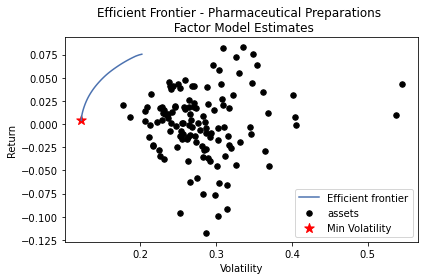

In [204]:
ef1 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - Pharmaceutical Preparations \n Factor Model Estimates")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility Portfolio

In [205]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.4%
Annual volatility: 12.2%
Sharpe Ratio: -0.13


<div>
<img src="images/min_vol_factor_model.png" width="300"/>
</div>

### Results for the Other 4 Industries

In [209]:
SIC_list = [7372, 1311, 6798, 6022]
SIC_desc = ['Prepackaged Software (mass reproduction of software)', 'Crude Petroleum and Natural Gas', 
           'Real Estate Investment Trusts', 'State Commercial Banks (commercial banking)']

#### Prepackaged Software (mass reproduction of software)

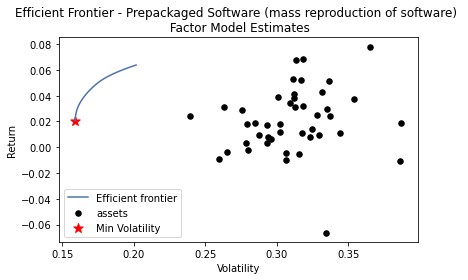

In [210]:
SIC = SIC_list[0]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))

LR = LinearRegression()
for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    reg = LR.fit(B_matrix, r_t_i)
    coef_mat.iloc[i] = reg.coef_

prediction = B_matrix.dot(coef_mat.T)
residual = r - prediction

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + np.diag(np.diag(residual.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index
cov_Factor_Model
    
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates' + str(industry_name) + '.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility Portfolio

In [211]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 2.1%
Annual volatility: 15.9%
Sharpe Ratio: 0.00


<div>
<img src="images/min_vol_factor_modelPrepackaged Software (mass reproduction of software).png" width="300"/>
</div>

#### Crude Petroleum and Natural Gas
When we conduct the same analysis, there is no weight shown. Efficient frontier cannot be found.

#### Real Estate Investment Trusts

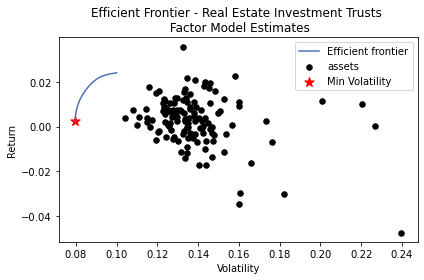

In [225]:
SIC = SIC_list[2]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))

LR = LinearRegression()
for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    reg = LR.fit(B_matrix, r_t_i)
    coef_mat.iloc[i] = reg.coef_

prediction = B_matrix.dot(coef_mat.T)
residual = r - prediction

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + np.diag(np.diag(residual.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index
cov_Factor_Model
    
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates' + str(industry_name) + '.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility Portfolio

In [226]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.3%
Annual volatility: 8.0%
Sharpe Ratio: -0.22


<div>
<img src="images/min_vol_factor_modelReal Estate Investment Trusts.png" width="300"/>
</div>

#### State Commercial Banks (commercial banking)

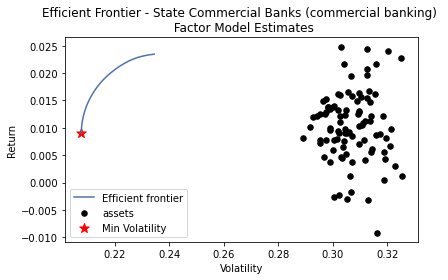

In [214]:
SIC = SIC_list[3]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))

LR = LinearRegression()
for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    reg = LR.fit(B_matrix, r_t_i)
    coef_mat.iloc[i] = reg.coef_

prediction = B_matrix.dot(coef_mat.T)
residual = r - prediction

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + np.diag(np.diag(residual.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index
cov_Factor_Model


# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates' + str(industry_name) + '.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility Portfolio

In [215]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.9%
Annual volatility: 20.8%
Sharpe Ratio: -0.05


<div>
<img src="images/min_vol_factor_modelState Commercial Banks (commercial banking).png" width="300"/>
</div>